In [1]:
!wandb login 
import wandb
from wandb.keras import WandbCallback

In [2]:
import os
os.chdir(os.environ["USERPROFILE"]+"/Desktop/Jupyter-GPU/data/nasa_planet_gan/")

In [3]:
from IPython import display as ipydisplay
from PIL import Image
from importlib import reload
import pickle
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import loadfunctions as lf
import tf_gan as tfg

In [4]:
!wandb login 
import wandb
from wandb.keras import WandbCallback

In [5]:
import os
os.chdir(os.environ["USERPROFILE"]+"/Desktop/Jupyter-GPU/data/nasa_planet_gan/")

In [6]:
from IPython import display as ipydisplay
from PIL import Image
from importlib import reload
import pickle
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import loadfunctions as lf
import tf_gan as tfg

In [7]:
input_width = 128
input_height = int(input_width*.75)
input_channels = 3
num_examples_to_generate = 16
noise_dim = 64
BATCH_SIZE = 128

In [8]:
reload(lf)
reload(tfg)

<module 'tf_gan' from 'C:\\Users\\Tasha\\Desktop\\Jupyter-GPU\\data\\nasa_planet_gan\\tf_gan.py'>

In [9]:
batch = tfg.create_batch(input_height,input_width, 20)
print(batch.shape)
grid = tfg.create_image_grid(batch,16)
tfg.get_image(grid).show()
#for i in range(0,180,10):    
#    ex1 = batch[0]
#    ex1 = lf._rotate_and_crop(ex1,input_height,input_width,i)
#    try:
#        ex1=ex1.numpy()
#    except:
#        pass
#    tfg.get_image(ex1).show()
#

#ex2 = lf._rotate_and_crop(ex1.numpy().copy(),input_height,input_width,35)
#get_image(ex2.numpy()).show()

#get_image(batch[-1]).show()
#get_image(batch[-2]).show()

#tf.image.resize
#batch = create_batch(2,2)
#tfg.get_image(batch[-0]).show()
#tfg.get_image(batch[-1]).show()
#tfg.get_image(batch[-2]).show()

In [10]:
ipydisplay.display(
tf.keras.preprocessing.image.array_to_img(batch[
    random.randint(0,len(batch))]))

In [11]:
X_train= batch

np.random.shuffle(X_train)
ipydisplay.display(tf.keras.preprocessing.image.array_to_img(X_train[0]))

test_num = int(len(X_train)*.1)
X = X_train[0:-test_num]
X_test = X_train[-test_num:]

print(f"X_train: {X.shape}, X_test: {X_test.shape}")

In [12]:
# function to provide the generator of the GAN
from tensorflow.keras.layers import BatchNormalization,Dense,Activation

def generator_model(output_width,
                    output_height,
                    output_channels,
                    latent_dim,
                    filters_list=[512,256,64,32,16,8,4,2],
                    dtype=tf.float32):
    w8 = int(output_width/8)
    h8 = int(output_height/8)
    con_t_layers=filters_list
    model = tf.keras.Sequential()
    model.add(layers.InputLayer((latent_dim)))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192),dtype=dtype ))
    model.add(BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192) ,dtype=dtype))
    model.add(BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))
    
    model.add(Dense(units=int(np.ceil(latent_dim/192)*192),dtype=dtype))
    model.add(BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))

    model.add(tf.keras.layers.Reshape(target_shape=(h8,w8,-1)))
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[0],kernel_size=(5,5),strides=(2,2),padding='same',dtype=dtype))
    model.add(tf.keras.layers.BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))

    model.add(tf.keras.layers.Conv2DTranspose(filters=con_t_layers[1],kernel_size=(5,5),strides=(2,2),padding='same',dtype=dtype))
    model.add(tf.keras.layers.BatchNormalization(dtype=dtype))
    model.add(Activation(activations.tanh,dtype=dtype))

    model.add(tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(5,5),strides=(2,2),padding='same',dtype=dtype))
    model.add(tf.keras.layers.Activation('tanh',dtype=dtype))
    #model.add(tf.keras.layers.Add(1.0))

    return model

In [13]:
# function to provide the discriminator of the GAN
def discriminator_model(dropout =.1, filters_list = [2**7,2**8,2**9]):
    drop_out_list = [dropout,
                     dropout,
                     dropout]
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.Dropout(drop_out_list[0]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[1],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[1]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Conv2D(filters=filters_list[2],kernel_size=(5,5),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.Dropout(drop_out_list[2]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

# function to provide the discriminator of the GAN
def discriminator_modelBroken():
    drop_out_list = [.5,.4,.33]
    filters_list = [8,16,32]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters_list[0],kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(input_height,input_width,input_channels)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=8))
    model.add(tf.keras.layers.Dense(units=4))
    model.add(tf.keras.layers.Dense(units=2))
    model.add(tf.keras.layers.Activation('tanh'))

    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('sigmoid'))
    return model

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss,real_loss,fake_loss

In [16]:
def generator_loss(fake_output):
    # generator wants to fool the discriminator
    # so we must define a loss function for the generator

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# selective discriminator on 5,6,7,8,9
# no selective discriminator on 1,2,3,4,

# tanh on 6,7,8,9

scale = 4 # 1,2
scale = 20 #4,5,6
scale = 15 #7
scale = 10 #3,8,9
scale = 4 #X

disc_dropout_scale =  1 # 1,2,3,4,5,6,7,8,
disc_dropout_scale = .5 # 9
disc_dropout_scale = .1 # X

orig_gen = 4e-5
orig_dis = 5e-7

mod_gen = 4e-5+4e-5 #1,2,3,4,5,6,7,8,9
mod_dis = 5e-7+0    #1,2,3,4,5,6,7,8,9
mod_dis = .9e-7+0    #X

ratio = (4e-5/.5e-6)
ratio = ((orig_gen)/
         (orig_dis))

gen_lr = mod_gen*scale
disc_lr = mod_dis*scale

In [18]:
generator = generator_model(output_width=input_width,
                            output_height=input_height,
                            output_channels=input_channels,
                            latent_dim= 512)
print(generator.summary())

In [19]:
discriminator = discriminator_model(dropout=disc_dropout_scale)
print(discriminator.summary())

#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=.000002,beta_1=.5)
#discriminator.compile(loss='binary_crossentropy',optimizer=discriminator_optimizer,metrics=['accuracy'])

In [20]:

# a= b/c
# b= ac
# c=b/a
print(gen_lr,disc_lr,ratio,gen_lr/disc_lr)
generator_optimizer     = tf.keras.optimizers.Adam(gen_lr)

In [21]:

discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr)

In [22]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
#run_exp.noise = tf.random.normal([use_batch_size, exp.latent_dim])   

In [23]:


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False).numpy()
  print(predictions.shape,predictions.dtype)
  fig = plt.figure(figsize=(8,2),dpi=160)
  #fig = plt.figure()

  for i in range(predictions.shape[0]):
      plt.subplot(2, 8, i+1)
      plt.imshow((predictions[i, :, :, :] * 255).astype(np.uint8))
      plt.axis('off')  
  plt.show()

def save_images(image = None,noise= None,generator= None,epoch=None):
    if not image:
        #print("noise: ",noise)
        predictions = generator(noise, training=False).numpy()
        #print(predictions.shape,predictions.dtype)

        # create hstack the images
        all = [(x,y) for x in range(8) for y in range(2)]

        for i,t in enumerate(all):
            x,y = t
            display.np_img[
                y*input_height:(y+1)*input_height,
                x*input_width:(x+1)*input_width,
                :] = predictions[i,:,:,:]
        img = Image.fromarray(((display.np_img+1)* 128).astype(np.uint8))
    
    else:
        img = image
    
    img.save('predictions_at_epoch_{:04d}.png'.format(epoch+1))
    wandb.log({"predictions":wandb.Image(img,"predictions")})
    return img

def display(models:[],
            epoch,
            epoch_max,
            results_history,
            tot_batches,
            noise,
            plot_graphs=True,
            plot_images=True,
            ):
    if "np_img" not in dir():
        display.np_img= np.zeros(
            (
                input_height*2,
                input_width*8,
                input_channels
            )
        )
    
    start = time.time()
    
    # Produce images for the GIF as you go
    ipydisplay.clear_output(wait=False)
    if plot_images:
        t = save_images(noise=noise,generator =models[0],epoch=epoch)        
        ipydisplay.display(t)
        
    if plot_graphs:
        clrs = plt.cm.get_cmap("hsv", len(results_history))
        # make the plot wide
        plt.figure(figsize=(8,2),dpi=160)
        for i, key in enumerate(results_history):
            if ('epoch' not in key) & (key != "fooled")&('_lr' not in key)&('scale' not in key):
                clr = clrs(i)
                clr=[
                     max(clr[0]-(i/255),0),
                     max(clr[1]-(i/255),0),
                     max(clr[2]-(i/255),0)
                 ]
                plot_history_clipped = prepare_series_for_graph(results_history[key][-1000:], clip=True, smooth=False)
                plot_history_clipped_smoothed = prepare_series_for_graph(results_history[key][-1000:], clip=True, smooth=True)

                plt.plot(plot_history_clipped, linewidth=.5, alpha=.35, color=clr)
                # use a thinner line for the smoothed results_history
                plt.plot(plot_history_clipped_smoothed, label=key + ' smoothed', linewidth=1,alpha=.8, color=clr)

        plt.legend(loc= 'upper left')
        plt.show()

        #plot_history_clipped = prepare_series_for_graph(results_history["fooled"][-1000:], clip=True, smooth=False)
        #plot_history_clipped_smoothed = prepare_series_for_graph(results_history["fooled"][-1000:], clip=True, smooth=True)

        plt.figure(figsize=(8,2),dpi=160)
        plt.rcParams.update({'font.size': 5})
        #plt.plot(plot_history_clipped, linewidth=.5, alpha=.33)
        # use a thinner line for the smoothed results_history

        #plt.yscale('log')
        #plt.ylim(0,20)
        #plt.plot(results_history["fooled_per"], label="fooled_per", linewidth=1,alpha =.80)
        plt.plot(results_history["g_grad_scale_accum"][-1000:], label="g_grad_scale_accum" ,  linewidth=1,alpha =1)
        plt.plot(results_history["d_grad_scale_accum"][-1000:], label="d_grad_scale_accum" ,  linewidth=1,alpha =1)
        plt.plot(results_history["equilibrium_scale"][-1000:], label="equilibrium_scale" ,  linewidth=1,alpha =1)
        plt.plot(results_history["grad_scale_power"][-1000:], label="grad_scale_power" ,  linewidth=1,alpha =1)
        plt.legend(loc= 'upper left')
        plt.show()
        
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    # print the results average using f strings

    def mean(lst:[]):
        try:
            return sum(lst) / len(lst)
        except tf.errors.InvalidArgumentError as e:
            return tf.reduce_mean(tf.cast(lst,tf.float32))
        
    if "current_epoch" in results_history:
        results_history["last_epoch"] = results_history['current_epoch']

    results_history['current_epoch']={ k+"_mean":mean(v[-100:]) for k,v in results_history.items() if type(v)==list}

    print(f"gen_loss: {results_history['current_epoch']['gen_loss_mean']}")
    print(f"disc_loss: {results_history['current_epoch']['disc_loss_mean']}")
    print(f"fooled_per: {results_history['current_epoch']['fooled_per_mean']}")
    print(f"g_grad_scale_accum: {results_history['current_epoch']['g_grad_scale_accum_mean']}")
    print(f"d_grad_scale_accum: {results_history['current_epoch']['d_grad_scale_accum_mean']}")
    print(f"Epoch: {epoch + 1} / {epoch_max}")
    print(f"Batches: {tot_batches}")
    print(f"D Time: {time.time() - start} for images: {plot_images} and graphs: {plot_graphs}")
    

In [24]:
def maintain_history(_results_history,_results):
    if len(_results_history)==1:
        #_results_history = dict(_results)
        for key in _results:
            if key != 'epoch':
                _results_history[key] = []
    else:
        # append results to results_history
        for key in _results_history:
            if 'epoch' not in key:
                _results_history[key].append(_results[key])


    return _results_history

In [25]:

def train(generator,
          discriminator,
          dataset,
          epochs,
          start_epoch,
          results_history,
          d_grad_scale_accum,
          g_grad_scale_accum,
          grad_scale_power,
          example_noise,
          use_grad_scale):

    if start_epoch == -1 and os.path.exists('results_history.pkl'):
        try:
            print("Loading results_history from file")
            results_history = pickle.load(open('results_history.pkl', 'rb'))
            start_epoch = results_history['epoch']
        except:
            print("Could not load results_history.pkl")
            start_epoch = 0
    elif start_epoch ==-1:
        results_history={'epoch': 0,
                    'disc_loss': [],
                    'real_loss': [],
                    'fake_loss': [],
                    'gen_loss': [],
                    'fooled': [],
                    'g_grad_scale_accum': [],
                    'd_grad_scale_accum': [],
                    'fooled_per': [],
                    'equilibrium_scale': [],
                    'grad_scale_power': []}
    elif (start_epoch > 0):
        start_epoch= results_history['epoch']
    
    #d_grad_scale_accum = tf.Variable(1.0)
    
    print("Starting from epoch: ", start_epoch)

    
    for epoch in range(start_epoch,start_epoch+epochs):
        wandb_callback.on_epoch_begin(epoch)
        results_history["epoch"] = epoch

        start = time.time()
        tot_batches = 0
        # train on each batch and generates/updates results history

        mstart = time.time()
        ts_total_time=0.0
        print("Starting epoch {}".format(epoch+1))
        for image_batch in dataset:
            # accumulate the results of each train_step
            ts_start_time = time.time()
            if'current_epoch' in results_history:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=results_history['current_epoch'],
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale,batch_num = tot_batches)
            else:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=None,
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale,batch_num = tot_batches)

            ts_time = time.time() - ts_start_time
            ts_total_time += ts_time
            #train._results['gen_lr'] = [generator_optimizer.learning_rate.numpy()]*train._results['batch_size']
            #train._results['disc_lr'] = discriminator_optimizer.learning_rate.numpy()
            results_history=maintain_history(results_history,train._results)
            tot_batches += 1
            wandb_callback.on_epoch_end(epoch)

        mend = time.time()
        print(f"Time for maintaining results: {mend - mstart-ts_total_time}")
        
        
        if epoch % 10 == 0:
            display.fig = plt.figure(figsize=(8,1.9),dpi=160)
            display([generator,discriminator],
                    epoch,
                    start_epoch+epochs,                    
                    results_history,
                    tot_batches,
                    noise=example_noise)
            # save results_history to disk as results_history.pkl
            with open('results_history.pkl', 'wb') as f:
                pickle.dump(results_history, f)
        save_images(noise=example_noise,generator =generator,epoch=epoch)
        print("Time for epoch: ", time.time() - start)

In [26]:
def prepare_series_for_graph(np_arr,smooth = True,clip =True):
    # print performance for this function
    s_time = time.time()
    out = np.array(np_arr)

    # smooth the results_history
    if smooth:
        out  = np.convolve(out, np.ones((10,))/10, mode='valid')
    # clip the results_history
    if clip:
        c=np.percentile(out, 95)
        out = out[out < c]
    e_time = time.time()
    #print(f"Time for smooth: {smooth} and clip: {clip} was {e_time - s_time}")

    return out.astype(np.float16)

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator,discriminator,
               images,               
               selective_discriminator_training,               
               hist,
               d_grad_scale_accum,
               g_grad_scale_accum,
               grad_scale_power,
               use_grad_scale:bool,
               batch_num):
    run = wandb.init(project="GAN1")
    noise = tf.random.normal((len(images),
                              generator.layers[0].input.shape[1]
                             ))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate noise to feed to the generator and get generated images.
        generated_images = generator(noise, training = generator.trainable)
        # call the discriminator with the real images and get its guesses
        real_output = discriminator(images, training = discriminator.trainable )
        # call the discriminator with the generated images and get the output
        fake_output = discriminator(generated_images, training = discriminator.trainable)
        gen_loss = generator_loss(fake_output)
        disc_loss,real_loss,fake_loss = discriminator_loss(real_output, fake_output)

    # track the number of fake images that fooled the discriminator where >.5
    fooled_per = tf.divide(tf.math.count_nonzero(fake_output > .5),BATCH_SIZE,"fooled_percent_calc")
    fooled = tf.math.count_nonzero(fake_output > .5)

    # Calculate the gradients for generator and discriminator.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)    
    report_d_grad_scale=1.0
    report_g_grad_scale=1.0
    equilibrium_scale=1.0
    #equilibrium_scale =tf.Variable(0,dtype=tf.float32)
    if use_grad_scale:
        #### Gen
        g_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        g_grad_scale = g_grad_scale * -2
        # range is -1 to +1, +1 when 100% of samples in batch DO NOT fool the discriminator
        g_grad_scale = g_grad_scale * grad_scale_power
        
        
        
        #### Disc
        d_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        d_grad_scale = d_grad_scale * 2
        # range is -1 to +1, +1 when 100% of samples in batch fool the discriminator
        d_grad_scale = d_grad_scale * grad_scale_power
        
        
        #equilibrium_scale=tf.cast((-((5*fooled_per)-2.5)**2+4)/6, dtype=tf.float32)*grad_scale_power
        equilibrium_scale=tf.cast((-((5.0*fooled_per)-2.0)**2.0+4.0)/4.0, dtype=tf.float32)*grad_scale_power
        #equilibrium_scale =(0.1(1/((fooled_per*4)−2)))**2
        
        d_grad_scale_accum.assign_add(d_grad_scale+equilibrium_scale)
        d_grad_scale_accum = tf.maximum(d_grad_scale_accum,-0.5)       
        d_grad_scale_tot = tf.constant(1.0, dtype=tf.float32) + d_grad_scale_accum
        

        g_grad_scale_accum.assign_add(g_grad_scale+equilibrium_scale)        
        g_grad_scale_accum = tf.maximum(g_grad_scale_accum,-0.5)
        g_grad_scale_tot = tf.cast(
            tf.add(tf.constant(1.0, dtype=tf.float32),g_grad_scale_accum),
            tf.float32)
        
        gradients_of_generator= [tf.math.scalar_mul(g_grad_scale_tot, grad) for grad in gradients_of_generator]
        gradients_of_discriminator= [tf.math.scalar_mul(d_grad_scale_tot,grad) for grad in gradients_of_discriminator]
                
        report_d_grad_scale=d_grad_scale_accum
        report_g_grad_scale=g_grad_scale_accum    
       
        
        
    # Apply gradients to the optimizer.
    generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    if selective_discriminator_training:
        if gen_loss < 1:
            #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
        discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # return a dictionary of disc_loss, real_loss, fake_loss, gen_loss,fooled
    disc_lr = tf.keras.backend.get_value(discriminator.optimizer.learning_rate)
    gen_lr = tf.keras.backend.get_value(generator.optimizer.learning_rate)
    
    

    wandb.log({'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gen_loss': gen_loss,
            'fooled': fooled,
            'g_grad_scale_accum': report_g_grad_scale,
            'd_grad_scale_accum': report_d_grad_scale,
            'fooled_per':fooled_per,
            'equilibrium_scale':equilibrium_scale,
            'grad_scale_power':grad_scale_power})

    return {'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gen_loss': gen_loss,
            'fooled': fooled,
            'g_grad_scale_accum': report_g_grad_scale,
            'd_grad_scale_accum': report_d_grad_scale,
            'fooled_per':fooled_per,
            'equilibrium_scale':equilibrium_scale,
            'grad_scale_power':grad_scale_power}

In [28]:

d_grad_scale_accum = tf.Variable(0.0)
g_grad_scale_accum = tf.Variable(0.0)

In [29]:
from dataclasses import dataclass
@dataclass
class experiment:
    name:str
    generator:None
    discriminator:None
    generator_src=None
    discriminator_src=None
    batch_size:int = 64
    train_shape:()=(0,0)
    example_noise = None
    g_lr:float=1e-6
    d_lr:float=1e-6
    start_gen_gsa:float=0.0
    start_disc_gsa:float=0.0
    grad_power:float=.01    
    epochs:int = 2000
    results_history=None
    use_grad_scale:bool=True
    latent_dim:int =100
    dropout:float=0.0
    disc_filters_list:list=None
    gen_filters_list:list=None
    
    

In [30]:
exp3 = experiment("exp3 - grad power higher .05",
                  g_lr=1e-6,
                  d_lr=1e-6,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=0.05,
                  batch_size=64,
                  epochs=2000)
print(exp3.results_history,exp3.batch_size)
#run_exp(exp3)

In [31]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-20,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

In [32]:
run = wandb.init(project="GAN1")
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-20,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

In [33]:
def save_models(gen,disc):
    gen.save("./generator.h5")
    disc.save("./discriminator.h5")
def summary_to_str(model):
    out=[]
    model.summary(print_fn=lambda x: out.append(x))
    out = '\n'.join(out)
    return out
    
def pre_save_exp(exp):
    import time    
    g_sum = summary_to_str(exp.generator)
    d_sum =  summary_to_str(exp.discriminator)
    os.popen(f'echo "{g_sum+d_sum}" > modal_summary.txt')
    print(g_sum)
    print(d_sum)    
    time.sleep(10)
            
             
def run_exp(exp:experiment):

    #global generator,discriminator
    #global discriminator_optimizer, generator_optimizer
    global train_step    
    global BATCH_SIZE
    if "exp" in os.getcwd():
        os.chdir("..")
    try:
        os.mkdir(f'exp-{exp.name}')
        os.chdir(f'exp-{exp.name}')
    except FileExistsError:
        os.chdir(f'exp-{exp.name}')
        if not exp.results_history:
            for f in os.listdir():
                try:
                    os.remove(f)
                except:
                    os.chdir(f)
                    for ff in os.listdir():
                        os.remove(ff)
                    os.chdir("..")
                    os.rmdir(f)
    
    try:
        train_step = train_step.python_function
    except:
        train_step = tf.function(train_step)

    lf.save_np_image_list(X_train,"augs")   
    
    if exp.discriminator is None:
        print("new discriminator")
        exp.discriminator = discriminator_model(dropout=exp.dropout,filters_list=exp.disc_filters_list)
        print("new discriminator optimizer")
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    if exp.results_history == None:
        #needed_records = (len(X_train)/exp.batch_size)*exp.epochs
        exp.results_history={'epoch':0}
        print("recreating models")
        
    
        exp.generator = generator_model(output_width=input_width,
                                        output_height=input_height,
                                        output_channels=input_channels,
                                        latent_dim =exp.latent_dim,dtype=tf.float32,
                                        filters_list = exp.gen_filters_list
                                       )

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        
        
        start =1
        epochs = 10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
    else:
        start=exp.results_history["epoch"]
        epochs=10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    
    ex_noise = tf.random.normal([16, exp.latent_dim])   
    if type(exp.batch_size) is list:
        if len(exp.batch_size) < exp.epochs:
            per = int(np.ceil( (exp.epochs/epochs)/len(exp.batch_size)))
            exp.batch_size = exp.batch_size*per
            #print(exp.batch_size)
    
    use_batch_size=-1
    
    pre_save_exp(exp)
    
    config = wandb.config
    wandb_callback = WandbCallback(
                        #training_data=train_dataset,
                        log__weights=(True),
                        #log_gradients=(True),
                        log_evaluation_frequency=1,
                        save_model=False,
                        model=exp.generator,
                )

    
    wandb_callback.set_model(exp.generator)
    wandb_callback.on_train_begin()
    exp_start_time = time.time()
    for ii,i in enumerate(range (start,start+exp.epochs,epochs)):
        old_batch_size=use_batch_size
        use_batch_size=exp.batch_size[ii]
        if old_batch_size != use_batch_size:
                old_batch_size=use_batch_size
                BATCH_SIZE= use_batch_size                
                slices = (X_train.astype("float16")/128)-1.0
                train_dataset = tf.data.Dataset.from_tensor_slices(slices).shuffle(len(X_train)).batch(use_batch_size)
                
        
        #regen noise even if batch_size is unchanged
        
        print("Batch size: ",use_batch_size)
        
        train(exp.generator,exp.discriminator,train_dataset,
                epochs=epochs,
                start_epoch=i,
                results_history=exp.results_history,
                d_grad_scale_accum = d_grad_scale_accum,
                g_grad_scale_accum = g_grad_scale_accum,
                grad_scale_power = grad_scale_power,
                example_noise= ex_noise,                
                use_grad_scale=exp.use_grad_scale
                )
       
    exp_run_time =time.time()-exp_start_time    
    with open("exp.data","x") as f:
        f.write(f'run time: {str(exp_run_time/60)} minutes\n')
        for i in dir(exp):
            if ('__' not in i) and ('results_history' not in i):        
                f.write(f'{str(i)} : {eval("exp."+str(i))} \n')
   
    plt.figure(figsize = (100,12))
    for k,v in exp.results_history.items():
        if( v.__class__ == list) and(k!="fooled"):
            print(k)
            skip = int(len(v)/14000.0)
            skip = min(skip,10)
            plt.plot(v[::skip])
    plt.savefig("plt.jpg")

    save_models(generator,discriminator)
    wandb_callback.on_train_end()

In [34]:
run = wandb.init(project="GAN1")
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-20,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

In [35]:
run = wandb.init(project="GAN1")
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-20,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss,real_loss,fake_loss

In [37]:
def generator_loss(fake_output):
    # generator wants to fool the discriminator
    # so we must define a loss function for the generator

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
# selective discriminator on 5,6,7,8,9
# no selective discriminator on 1,2,3,4,

# tanh on 6,7,8,9

scale = 4 # 1,2
scale = 20 #4,5,6
scale = 15 #7
scale = 10 #3,8,9
scale = 4 #X

disc_dropout_scale =  1 # 1,2,3,4,5,6,7,8,
disc_dropout_scale = .5 # 9
disc_dropout_scale = .1 # X

orig_gen = 4e-5
orig_dis = 5e-7

mod_gen = 4e-5+4e-5 #1,2,3,4,5,6,7,8,9
mod_dis = 5e-7+0    #1,2,3,4,5,6,7,8,9
mod_dis = .9e-7+0    #X

ratio = (4e-5/.5e-6)
ratio = ((orig_gen)/
         (orig_dis))

gen_lr = mod_gen*scale
disc_lr = mod_dis*scale

In [39]:
generator = generator_model(output_width=input_width,
                            output_height=input_height,
                            output_channels=input_channels,
                            latent_dim= 512)
print(generator.summary())

In [40]:
discriminator = discriminator_model(dropout=disc_dropout_scale)
print(discriminator.summary())

#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=.000002,beta_1=.5)
#discriminator.compile(loss='binary_crossentropy',optimizer=discriminator_optimizer,metrics=['accuracy'])

In [41]:

# a= b/c
# b= ac
# c=b/a
print(gen_lr,disc_lr,ratio,gen_lr/disc_lr)
generator_optimizer     = tf.keras.optimizers.Adam(gen_lr)

In [42]:

discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr)

In [43]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
#run_exp.noise = tf.random.normal([use_batch_size, exp.latent_dim])   

In [44]:


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False).numpy()
  print(predictions.shape,predictions.dtype)
  fig = plt.figure(figsize=(8,2),dpi=160)
  #fig = plt.figure()

  for i in range(predictions.shape[0]):
      plt.subplot(2, 8, i+1)
      plt.imshow((predictions[i, :, :, :] * 255).astype(np.uint8))
      plt.axis('off')  
  plt.show()

def save_images(image = None,noise= None,generator= None,epoch=None):
    if not image:
        #print("noise: ",noise)
        predictions = generator(noise, training=False).numpy()
        #print(predictions.shape,predictions.dtype)

        # create hstack the images
        all = [(x,y) for x in range(8) for y in range(2)]

        for i,t in enumerate(all):
            x,y = t
            display.np_img[
                y*input_height:(y+1)*input_height,
                x*input_width:(x+1)*input_width,
                :] = predictions[i,:,:,:]
        img = Image.fromarray(((display.np_img+1)* 128).astype(np.uint8))
    
    else:
        img = image
    
    img.save('predictions_at_epoch_{:04d}.png'.format(epoch+1))
    wandb.log({"predictions":wandb.Image(img,"predictions")})
    return img

def display(models:[],
            epoch,
            epoch_max,
            results_history,
            tot_batches,
            noise,
            plot_graphs=True,
            plot_images=True,
            ):
    if "np_img" not in dir():
        display.np_img= np.zeros(
            (
                input_height*2,
                input_width*8,
                input_channels
            )
        )
    
    start = time.time()
    
    # Produce images for the GIF as you go
    ipydisplay.clear_output(wait=False)
    if plot_images:
        t = save_images(noise=noise,generator =models[0],epoch=epoch)        
        ipydisplay.display(t)
        
    if plot_graphs:
        clrs = plt.cm.get_cmap("hsv", len(results_history))
        # make the plot wide
        plt.figure(figsize=(8,2),dpi=160)
        for i, key in enumerate(results_history):
            if ('epoch' not in key) & (key != "fooled")&('_lr' not in key)&('scale' not in key):
                clr = clrs(i)
                clr=[
                     max(clr[0]-(i/255),0),
                     max(clr[1]-(i/255),0),
                     max(clr[2]-(i/255),0)
                 ]
                plot_history_clipped = prepare_series_for_graph(results_history[key][-1000:], clip=True, smooth=False)
                plot_history_clipped_smoothed = prepare_series_for_graph(results_history[key][-1000:], clip=True, smooth=True)

                plt.plot(plot_history_clipped, linewidth=.5, alpha=.35, color=clr)
                # use a thinner line for the smoothed results_history
                plt.plot(plot_history_clipped_smoothed, label=key + ' smoothed', linewidth=1,alpha=.8, color=clr)

        plt.legend(loc= 'upper left')
        plt.show()

        #plot_history_clipped = prepare_series_for_graph(results_history["fooled"][-1000:], clip=True, smooth=False)
        #plot_history_clipped_smoothed = prepare_series_for_graph(results_history["fooled"][-1000:], clip=True, smooth=True)

        plt.figure(figsize=(8,2),dpi=160)
        plt.rcParams.update({'font.size': 5})
        #plt.plot(plot_history_clipped, linewidth=.5, alpha=.33)
        # use a thinner line for the smoothed results_history

        #plt.yscale('log')
        #plt.ylim(0,20)
        #plt.plot(results_history["fooled_per"], label="fooled_per", linewidth=1,alpha =.80)
        plt.plot(results_history["g_grad_scale_accum"][-1000:], label="g_grad_scale_accum" ,  linewidth=1,alpha =1)
        plt.plot(results_history["d_grad_scale_accum"][-1000:], label="d_grad_scale_accum" ,  linewidth=1,alpha =1)
        plt.plot(results_history["equilibrium_scale"][-1000:], label="equilibrium_scale" ,  linewidth=1,alpha =1)
        plt.plot(results_history["grad_scale_power"][-1000:], label="grad_scale_power" ,  linewidth=1,alpha =1)
        plt.legend(loc= 'upper left')
        plt.show()
        
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    # print the results average using f strings

    def mean(lst:[]):
        try:
            return sum(lst) / len(lst)
        except tf.errors.InvalidArgumentError as e:
            return tf.reduce_mean(tf.cast(lst,tf.float32))
        
    if "current_epoch" in results_history:
        results_history["last_epoch"] = results_history['current_epoch']

    results_history['current_epoch']={ k+"_mean":mean(v[-100:]) for k,v in results_history.items() if type(v)==list}

    print(f"gen_loss: {results_history['current_epoch']['gen_loss_mean']}")
    print(f"disc_loss: {results_history['current_epoch']['disc_loss_mean']}")
    print(f"fooled_per: {results_history['current_epoch']['fooled_per_mean']}")
    print(f"g_grad_scale_accum: {results_history['current_epoch']['g_grad_scale_accum_mean']}")
    print(f"d_grad_scale_accum: {results_history['current_epoch']['d_grad_scale_accum_mean']}")
    print(f"Epoch: {epoch + 1} / {epoch_max}")
    print(f"Batches: {tot_batches}")
    print(f"D Time: {time.time() - start} for images: {plot_images} and graphs: {plot_graphs}")
    

In [45]:
def maintain_history(_results_history,_results):
    if len(_results_history)==1:
        #_results_history = dict(_results)
        for key in _results:
            if key != 'epoch':
                _results_history[key] = []
    else:
        # append results to results_history
        for key in _results_history:
            if 'epoch' not in key:
                _results_history[key].append(_results[key])


    return _results_history

In [46]:

def train(generator,
          discriminator,
          dataset,
          epochs,
          start_epoch,
          results_history,
          d_grad_scale_accum,
          g_grad_scale_accum,
          grad_scale_power,
          example_noise,
          use_grad_scale):

    if start_epoch == -1 and os.path.exists('results_history.pkl'):
        try:
            print("Loading results_history from file")
            results_history = pickle.load(open('results_history.pkl', 'rb'))
            start_epoch = results_history['epoch']
        except:
            print("Could not load results_history.pkl")
            start_epoch = 0
    elif start_epoch ==-1:
        results_history={'epoch': 0,
                    'disc_loss': [],
                    'real_loss': [],
                    'fake_loss': [],
                    'gen_loss': [],
                    'fooled': [],
                    'g_grad_scale_accum': [],
                    'd_grad_scale_accum': [],
                    'fooled_per': [],
                    'equilibrium_scale': [],
                    'grad_scale_power': []}
    elif (start_epoch > 0):
        start_epoch= results_history['epoch']
    
    #d_grad_scale_accum = tf.Variable(1.0)
    
    print("Starting from epoch: ", start_epoch)

    
    for epoch in range(start_epoch,start_epoch+epochs):
        
        results_history["epoch"] = epoch

        start = time.time()
        tot_batches = 0
        # train on each batch and generates/updates results history

        mstart = time.time()
        ts_total_time=0.0
        print("Starting epoch {}".format(epoch+1))
        for image_batch in dataset:
            # accumulate the results of each train_step
            ts_start_time = time.time()
            if'current_epoch' in results_history:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=results_history['current_epoch'],
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale,batch_num = tot_batches)
            else:
                train._results = train_step(generator,discriminator,image_batch,
                                            selective_discriminator_training=False,
                                            hist=None,
                                            d_grad_scale_accum= d_grad_scale_accum,
                                            g_grad_scale_accum=g_grad_scale_accum,
                                            grad_scale_power=grad_scale_power,
                                            use_grad_scale=use_grad_scale,batch_num = tot_batches)

            ts_time = time.time() - ts_start_time
            ts_total_time += ts_time
            #train._results['gen_lr'] = [generator_optimizer.learning_rate.numpy()]*train._results['batch_size']
            #train._results['disc_lr'] = discriminator_optimizer.learning_rate.numpy()
            results_history=maintain_history(results_history,train._results)
            tot_batches += 1
            

        mend = time.time()
        print(f"Time for maintaining results: {mend - mstart-ts_total_time}")
        
        
        if epoch % 10 == 0:
            display.fig = plt.figure(figsize=(8,1.9),dpi=160)
            display([generator,discriminator],
                    epoch,
                    start_epoch+epochs,                    
                    results_history,
                    tot_batches,
                    noise=example_noise)
            # save results_history to disk as results_history.pkl
            with open('results_history.pkl', 'wb') as f:
                pickle.dump(results_history, f)
        save_images(noise=example_noise,generator =generator,epoch=epoch)
        print("Time for epoch: ", time.time() - start)

In [47]:
def prepare_series_for_graph(np_arr,smooth = True,clip =True):
    # print performance for this function
    s_time = time.time()
    out = np.array(np_arr)

    # smooth the results_history
    if smooth:
        out  = np.convolve(out, np.ones((10,))/10, mode='valid')
    # clip the results_history
    if clip:
        c=np.percentile(out, 95)
        out = out[out < c]
    e_time = time.time()
    #print(f"Time for smooth: {smooth} and clip: {clip} was {e_time - s_time}")

    return out.astype(np.float16)

In [48]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator,discriminator,
               images,               
               selective_discriminator_training,               
               hist,
               d_grad_scale_accum,
               g_grad_scale_accum,
               grad_scale_power,
               use_grad_scale:bool,
               batch_num):
    
    noise = tf.random.normal((len(images),
                              generator.layers[0].input.shape[1]
                             ))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate noise to feed to the generator and get generated images.
        generated_images = generator(noise, training = generator.trainable)
        # call the discriminator with the real images and get its guesses
        real_output = discriminator(images, training = discriminator.trainable )
        # call the discriminator with the generated images and get the output
        fake_output = discriminator(generated_images, training = discriminator.trainable)
        gen_loss = generator_loss(fake_output)
        disc_loss,real_loss,fake_loss = discriminator_loss(real_output, fake_output)

    # track the number of fake images that fooled the discriminator where >.5
    fooled_per = tf.divide(tf.math.count_nonzero(fake_output > .5),BATCH_SIZE,"fooled_percent_calc")
    fooled = tf.math.count_nonzero(fake_output > .5)

    # Calculate the gradients for generator and discriminator.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)    
    report_d_grad_scale=1.0
    report_g_grad_scale=1.0
    equilibrium_scale=1.0
    #equilibrium_scale =tf.Variable(0,dtype=tf.float32)
    if use_grad_scale:
        #### Gen
        g_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        g_grad_scale = g_grad_scale * -2
        # range is -1 to +1, +1 when 100% of samples in batch DO NOT fool the discriminator
        g_grad_scale = g_grad_scale * grad_scale_power
        
        
        
        #### Disc
        d_grad_scale = tf.subtract(            
            tf.cast(fooled_per ,dtype=tf.float32),
            tf.constant(.5, dtype=tf.float32)
        )
        d_grad_scale = d_grad_scale * 2
        # range is -1 to +1, +1 when 100% of samples in batch fool the discriminator
        d_grad_scale = d_grad_scale * grad_scale_power
        
        
        #equilibrium_scale=tf.cast((-((5*fooled_per)-2.5)**2+4)/6, dtype=tf.float32)*grad_scale_power
        equilibrium_scale=tf.cast((-((5.0*fooled_per)-2.0)**2.0+4.0)/4.0, dtype=tf.float32)*grad_scale_power
        #equilibrium_scale =(0.1(1/((fooled_per*4)−2)))**2
        
        d_grad_scale_accum.assign_add(d_grad_scale+equilibrium_scale)
        d_grad_scale_accum = tf.maximum(d_grad_scale_accum,-0.5)       
        d_grad_scale_tot = tf.constant(1.0, dtype=tf.float32) + d_grad_scale_accum
        

        g_grad_scale_accum.assign_add(g_grad_scale+equilibrium_scale)        
        g_grad_scale_accum = tf.maximum(g_grad_scale_accum,-0.5)
        g_grad_scale_tot = tf.cast(
            tf.add(tf.constant(1.0, dtype=tf.float32),g_grad_scale_accum),
            tf.float32)
        
        gradients_of_generator= [tf.math.scalar_mul(g_grad_scale_tot, grad) for grad in gradients_of_generator]
        gradients_of_discriminator= [tf.math.scalar_mul(d_grad_scale_tot,grad) for grad in gradients_of_discriminator]
                
        report_d_grad_scale=d_grad_scale_accum
        report_g_grad_scale=g_grad_scale_accum    
       
        
        
    # Apply gradients to the optimizer.
    generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    if selective_discriminator_training:
        if gen_loss < 1:
            #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
        discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # return a dictionary of disc_loss, real_loss, fake_loss, gen_loss,fooled
    disc_lr = tf.keras.backend.get_value(discriminator.optimizer.learning_rate)
    gen_lr = tf.keras.backend.get_value(generator.optimizer.learning_rate)
    
    

    wandb.log({'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gen_loss': gen_loss,
            'fooled': fooled,
            'g_grad_scale_accum': report_g_grad_scale,
            'd_grad_scale_accum': report_d_grad_scale,
            'fooled_per':fooled_per,
            'equilibrium_scale':equilibrium_scale,
            'grad_scale_power':grad_scale_power})

    return {'disc_loss': disc_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gen_loss': gen_loss,
            'fooled': fooled,
            'g_grad_scale_accum': report_g_grad_scale,
            'd_grad_scale_accum': report_d_grad_scale,
            'fooled_per':fooled_per,
            'equilibrium_scale':equilibrium_scale,
            'grad_scale_power':grad_scale_power}

In [49]:

d_grad_scale_accum = tf.Variable(0.0)
g_grad_scale_accum = tf.Variable(0.0)

In [50]:
from dataclasses import dataclass
@dataclass
class experiment:
    name:str
    generator:None
    discriminator:None
    generator_src=None
    discriminator_src=None
    batch_size:int = 64
    train_shape:()=(0,0)
    example_noise = None
    g_lr:float=1e-6
    d_lr:float=1e-6
    start_gen_gsa:float=0.0
    start_disc_gsa:float=0.0
    grad_power:float=.01    
    epochs:int = 2000
    results_history=None
    use_grad_scale:bool=True
    latent_dim:int =100
    dropout:float=0.0
    disc_filters_list:list=None
    gen_filters_list:list=None
    
    

In [51]:
run = wandb.init(project="GAN1")
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-20,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

In [52]:
run = wandb.init(project="GAN1")
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-4,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

d_grad_scale_accum,███████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
d_lr,▁
disc_loss,▅▆▆█▆▅▄▄▃▃▄▄▂▃▂▃▂▂▂▂▂▁▁▁▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁
dropout,▁
epochs,▁
equilibrium_scale,██▁██▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fake_loss,▇▆▃▇█▅▃▃▅▄▂▆▃▄▃▄▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
fooled,██▁██▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fooled_per,██▁██▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
g_grad_scale_accum,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
g_lr,▁


In [53]:
def save_models(gen,disc):
    gen.save("./generator.h5")
    disc.save("./discriminator.h5")
def summary_to_str(model):
    out=[]
    model.summary(print_fn=lambda x: out.append(x))
    out = '\n'.join(out)
    return out
    
def pre_save_exp(exp):
    import time    
    g_sum = summary_to_str(exp.generator)
    d_sum =  summary_to_str(exp.discriminator)
    os.popen(f'echo "{g_sum+d_sum}" > modal_summary.txt')
    print(g_sum)
    print(d_sum)    
    time.sleep(10)
            
             
def run_exp(exp:experiment):

    #global generator,discriminator
    #global discriminator_optimizer, generator_optimizer
    global train_step    
    global BATCH_SIZE
    if "exp" in os.getcwd():
        os.chdir("..")
    try:
        os.mkdir(f'exp-{exp.name}')
        os.chdir(f'exp-{exp.name}')
    except FileExistsError:
        os.chdir(f'exp-{exp.name}')
        if not exp.results_history:
            for f in os.listdir():
                try:
                    os.remove(f)
                except:
                    os.chdir(f)
                    for ff in os.listdir():
                        os.remove(ff)
                    os.chdir("..")
                    os.rmdir(f)
    
    try:
        train_step = train_step.python_function
    except:
        train_step = tf.function(train_step)

    lf.save_np_image_list(X_train,"augs")   
    
    if exp.discriminator is None:
        print("new discriminator")
        exp.discriminator = discriminator_model(dropout=exp.dropout,filters_list=exp.disc_filters_list)
        print("new discriminator optimizer")
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    if exp.results_history == None:
        #needed_records = (len(X_train)/exp.batch_size)*exp.epochs
        exp.results_history={'epoch':0}
        print("recreating models")
        
    
        exp.generator = generator_model(output_width=input_width,
                                        output_height=input_height,
                                        output_channels=input_channels,
                                        latent_dim =exp.latent_dim,dtype=tf.float32,
                                        filters_list = exp.gen_filters_list
                                       )

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        
        
        start =1
        epochs = 10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
    else:
        start=exp.results_history["epoch"]
        epochs=10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    
    ex_noise = tf.random.normal([16, exp.latent_dim])   
    if type(exp.batch_size) is list:
        if len(exp.batch_size) < exp.epochs:
            per = int(np.ceil( (exp.epochs/epochs)/len(exp.batch_size)))
            exp.batch_size = exp.batch_size*per
            #print(exp.batch_size)
    
    use_batch_size=-1
    
    pre_save_exp(exp)
    
    config = wandb.config

    exp_start_time = time.time()
    for ii,i in enumerate(range (start,start+exp.epochs,epochs)):
        old_batch_size=use_batch_size
        use_batch_size=exp.batch_size[ii]
        if old_batch_size != use_batch_size:
                old_batch_size=use_batch_size
                BATCH_SIZE= use_batch_size                
                slices = (X_train.astype("float16")/128)-1.0
                train_dataset = tf.data.Dataset.from_tensor_slices(slices).shuffle(len(X_train)).batch(use_batch_size)
                wandb.log({"batch_size":use_batch_size})
                
        
        #regen noise even if batch_size is unchanged
        
        print("Batch size: ",use_batch_size)
        
        train(exp.generator,exp.discriminator,train_dataset,
                epochs=epochs,
                start_epoch=i,
                results_history=exp.results_history,
                d_grad_scale_accum = d_grad_scale_accum,
                g_grad_scale_accum = g_grad_scale_accum,
                grad_scale_power = grad_scale_power,
                example_noise= ex_noise,                
                use_grad_scale=exp.use_grad_scale
                )
       
    exp_run_time =time.time()-exp_start_time    
    with open("exp.data","x") as f:
        f.write(f'run time: {str(exp_run_time/60)} minutes\n')
        for i in dir(exp):
            if ('__' not in i) and ('results_history' not in i):        
                f.write(f'{str(i)} : {eval("exp."+str(i))} \n')
   
    plt.figure(figsize = (100,12))
    for k,v in exp.results_history.items():
        if( v.__class__ == list) and(k!="fooled"):
            print(k)
            skip = int(len(v)/14000.0)
            skip = min(skip,10)
            plt.plot(v[::skip])
    plt.savefig("plt.jpg")

    save_models(generator,discriminator)    

In [54]:
def save_models(gen,disc):
    gen.save("./generator.h5")
    disc.save("./discriminator.h5")
def summary_to_str(model):
    out=[]
    model.summary(print_fn=lambda x: out.append(x))
    out = '\n'.join(out)
    return out
    
def pre_save_exp(exp):
    import time    
    g_sum = summary_to_str(exp.generator)
    d_sum =  summary_to_str(exp.discriminator)
    os.popen(f'echo "{g_sum+d_sum}" > modal_summary.txt')
    print(g_sum)
    print(d_sum)    
    time.sleep(10)
            
             
def run_exp(exp:experiment):

    #global generator,discriminator
    #global discriminator_optimizer, generator_optimizer
    global train_step    
    global BATCH_SIZE
    if "exp" in os.getcwd():
        os.chdir("..")
    try:
        os.mkdir(f'exp-{exp.name}')
        os.chdir(f'exp-{exp.name}')
    except FileExistsError:
        os.chdir(f'exp-{exp.name}')
        if not exp.results_history:
            for f in os.listdir():
                try:
                    os.remove(f)
                except:
                    os.chdir(f)
                    for ff in os.listdir():
                        os.remove(ff)
                    os.chdir("..")
                    os.rmdir(f)
    
    try:
        train_step = train_step.python_function
    except:
        train_step = tf.function(train_step)

    lf.save_np_image_list(X_train,"augs")   
    
    if exp.discriminator is None:
        print("new discriminator")
        exp.discriminator = discriminator_model(dropout=exp.dropout,filters_list=exp.disc_filters_list)
        print("new discriminator optimizer")
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    if exp.results_history == None:
        #needed_records = (len(X_train)/exp.batch_size)*exp.epochs
        exp.results_history={'epoch':0}
        print("recreating models")
        
    
        exp.generator = generator_model(output_width=input_width,
                                        output_height=input_height,
                                        output_channels=input_channels,
                                        latent_dim =exp.latent_dim,dtype=tf.float32,
                                        filters_list = exp.gen_filters_list
                                       )

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        
        
        start =1
        epochs = 10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
    else:
        run = wandb.init(project="GAN1")
        start=exp.results_history["epoch"]
        epochs=10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    
    ex_noise = tf.random.normal([16, exp.latent_dim])   
    if type(exp.batch_size) is list:
        if len(exp.batch_size) < exp.epochs:
            per = int(np.ceil( (exp.epochs/epochs)/len(exp.batch_size)))
            exp.batch_size = exp.batch_size*per
            #print(exp.batch_size)
    
    use_batch_size=-1
    
    pre_save_exp(exp)
    
    config = wandb.config

    exp_start_time = time.time()
    for ii,i in enumerate(range (start,start+exp.epochs,epochs)):
        old_batch_size=use_batch_size
        use_batch_size=exp.batch_size[ii]
        if old_batch_size != use_batch_size:
                old_batch_size=use_batch_size
                BATCH_SIZE= use_batch_size                
                slices = (X_train.astype("float16")/128)-1.0
                train_dataset = tf.data.Dataset.from_tensor_slices(slices).shuffle(len(X_train)).batch(use_batch_size)
                wandb.log({"batch_size":use_batch_size})
                
        
        #regen noise even if batch_size is unchanged
        
        print("Batch size: ",use_batch_size)
        
        train(exp.generator,exp.discriminator,train_dataset,
                epochs=epochs,
                start_epoch=i,
                results_history=exp.results_history,
                d_grad_scale_accum = d_grad_scale_accum,
                g_grad_scale_accum = g_grad_scale_accum,
                grad_scale_power = grad_scale_power,
                example_noise= ex_noise,                
                use_grad_scale=exp.use_grad_scale
                )
       
    exp_run_time =time.time()-exp_start_time    
    with open("exp.data","x") as f:
        f.write(f'run time: {str(exp_run_time/60)} minutes\n')
        for i in dir(exp):
            if ('__' not in i) and ('results_history' not in i):        
                f.write(f'{str(i)} : {eval("exp."+str(i))} \n')
   
    plt.figure(figsize = (100,12))
    for k,v in exp.results_history.items():
        if( v.__class__ == list) and(k!="fooled"):
            print(k)
            skip = int(len(v)/14000.0)
            skip = min(skip,10)
            plt.plot(v[::skip])
    plt.savefig("plt.jpg")

    save_models(generator,discriminator)    

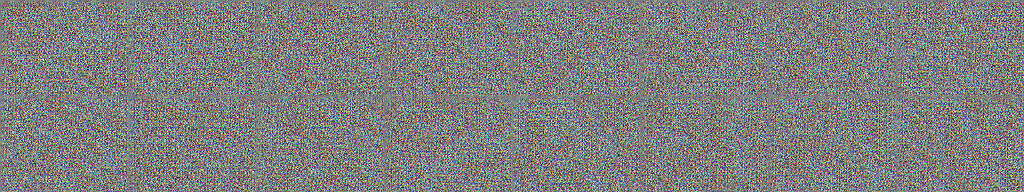

<Figure size 1280x304 with 0 Axes>

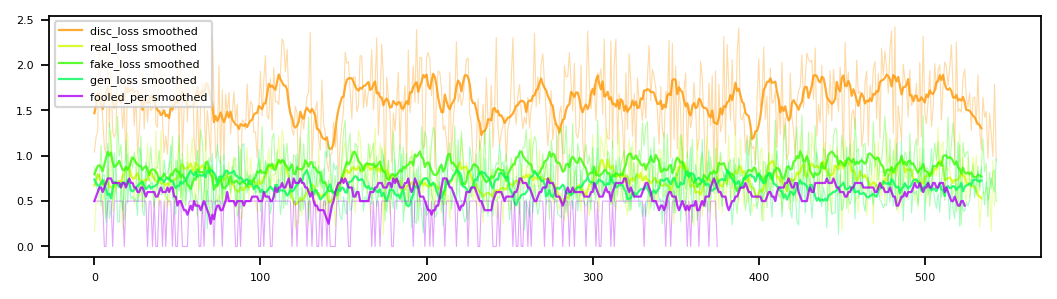

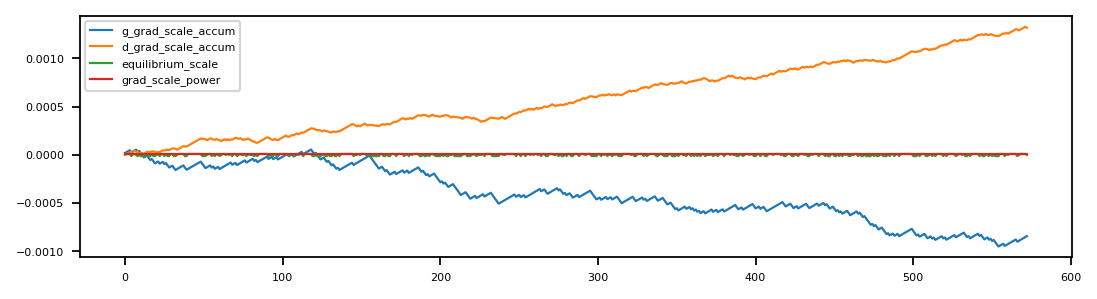

In [55]:

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 1.0e-4,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log(exp.__dict__)
    run_exp(exp)

In [56]:

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 5.0e-4,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log({"exp_"+k:v for k,v in exp.__dict__.items()})
    run_exp(exp)

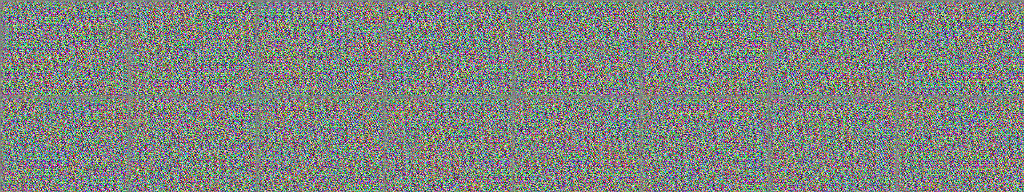

<Figure size 1280x304 with 0 Axes>

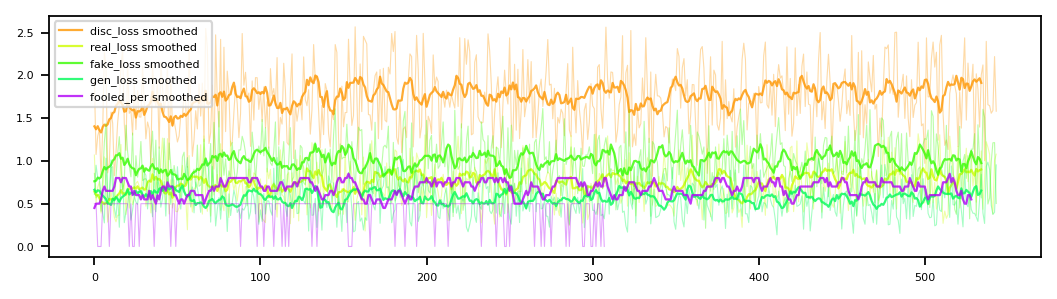

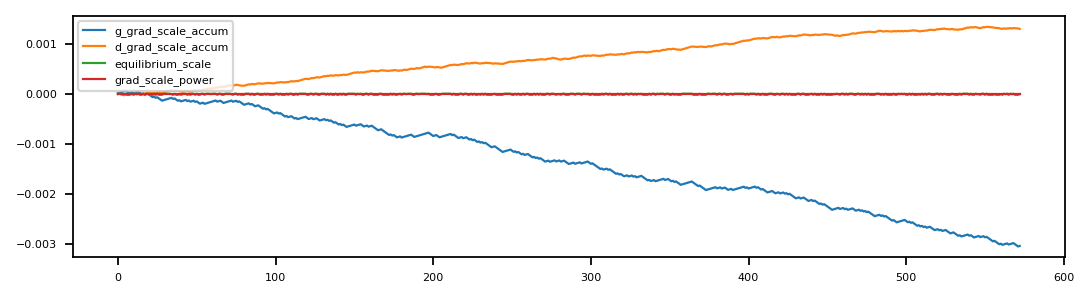

In [57]:

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 5.0e-4,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log({"exp_"+k:v for k,v in exp.__dict__.items()})
    run_exp(exp)

In [58]:
def save_models(gen,disc):
    gen.save("./generator.h5")
    disc.save("./discriminator.h5")
def summary_to_str(model):
    out=[]
    model.summary(print_fn=lambda x: out.append(x))
    out = '\n'.join(out)
    return out
    
def pre_save_exp(exp):
    import time    
    g_sum = summary_to_str(exp.generator)
    d_sum =  summary_to_str(exp.discriminator)
    os.popen(f'echo "{g_sum+d_sum}" > modal_summary.txt')
    print(g_sum)
    print(d_sum)    
    time.sleep(10)
            
             
def run_exp(exp:experiment):

    #global generator,discriminator
    #global discriminator_optimizer, generator_optimizer
    global train_step    
    global BATCH_SIZE
    if "exp" in os.getcwd():
        os.chdir("..")
    try:
        os.mkdir(f'exp-{exp.name}')
        os.chdir(f'exp-{exp.name}')
    except FileExistsError:
        os.chdir(f'exp-{exp.name}')
        if not exp.results_history:
            for f in os.listdir():
                try:
                    os.remove(f)
                except:
                    os.chdir(f)
                    for ff in os.listdir():
                        os.remove(ff)
                    os.chdir("..")
                    os.rmdir(f)
    
    try:
        train_step = train_step.python_function
    except:
        train_step = tf.function(train_step)

    lf.save_np_image_list(X_train,"augs")   
    
    if exp.discriminator is None:
        print("new discriminator")
        exp.discriminator = discriminator_model(dropout=exp.dropout,filters_list=exp.disc_filters_list)
        print("new discriminator optimizer")
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    if exp.results_history == None:
        run = wandb.init(project="GAN1")
        #needed_records = (len(X_train)/exp.batch_size)*exp.epochs
        exp.results_history={'epoch':0}
        print("recreating models")
        
    
        exp.generator = generator_model(output_width=input_width,
                                        output_height=input_height,
                                        output_channels=input_channels,
                                        latent_dim =exp.latent_dim,dtype=tf.float32,
                                        filters_list = exp.gen_filters_list
                                       )

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        
        
        start =1
        epochs = 10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)
    else:        
        start=exp.results_history["epoch"]
        epochs=10
        BATCH_SIZE = exp.batch_size
        d_grad_scale_accum = tf.Variable(exp.start_disc_gsa)
        g_grad_scale_accum = tf.Variable(exp.start_gen_gsa)
        grad_scale_power = tf.Variable(exp.grad_power)

        exp.generator.optimizer     = tf.keras.optimizers.Adam(exp.g_lr)
        exp.discriminator.optimizer = tf.keras.optimizers.Adam(exp.d_lr)
        
    
    ex_noise = tf.random.normal([16, exp.latent_dim])   
    if type(exp.batch_size) is list:
        if len(exp.batch_size) < exp.epochs:
            per = int(np.ceil( (exp.epochs/epochs)/len(exp.batch_size)))
            exp.batch_size = exp.batch_size*per
            #print(exp.batch_size)
    
    use_batch_size=-1
    
    pre_save_exp(exp)
    
    config = wandb.config

    exp_start_time = time.time()
    for ii,i in enumerate(range (start,start+exp.epochs,epochs)):
        old_batch_size=use_batch_size
        use_batch_size=exp.batch_size[ii]
        if old_batch_size != use_batch_size:
                old_batch_size=use_batch_size
                BATCH_SIZE= use_batch_size                
                slices = (X_train.astype("float16")/128)-1.0
                train_dataset = tf.data.Dataset.from_tensor_slices(slices).shuffle(len(X_train)).batch(use_batch_size)
                wandb.log({"batch_size":use_batch_size})
                
        
        #regen noise even if batch_size is unchanged
        
        print("Batch size: ",use_batch_size)
        
        train(exp.generator,exp.discriminator,train_dataset,
                epochs=epochs,
                start_epoch=i,
                results_history=exp.results_history,
                d_grad_scale_accum = d_grad_scale_accum,
                g_grad_scale_accum = g_grad_scale_accum,
                grad_scale_power = grad_scale_power,
                example_noise= ex_noise,                
                use_grad_scale=exp.use_grad_scale
                )
       
    exp_run_time =time.time()-exp_start_time    
    with open("exp.data","x") as f:
        f.write(f'run time: {str(exp_run_time/60)} minutes\n')
        for i in dir(exp):
            if ('__' not in i) and ('results_history' not in i):        
                f.write(f'{str(i)} : {eval("exp."+str(i))} \n')
   
    plt.figure(figsize = (100,12))
    for k,v in exp.results_history.items():
        if( v.__class__ == list) and(k!="fooled"):
            print(k)
            skip = int(len(v)/14000.0)
            skip = min(skip,10)
            plt.plot(v[::skip])
    plt.savefig("plt.jpg")

    save_models(generator,discriminator)    

In [59]:

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

t=[[b]*i for i,b in enumerate(range(1,32))]
o=[]
for i in t:
    o = o + i
exp_tmp = [experiment(f'crazy batch small filters',
                  generator=None,
                  discriminator=None,
                  g_lr = 5.0e-4,
                  d_lr = lr,
                  start_gen_gsa=0.0,
                  start_disc_gsa=0.0,
                  grad_power=.00001,
                  batch_size=bs,
                  epochs=1000,
                  latent_dim = ld,
                  dropout=dropout,
                  disc_filters_list = d_filters,
                  gen_filters_list = g_filters
                  )
for ld,dropout,lr,bs,d_filters,g_filters in [
    (200,.33,2.50e-6,o,[64+32+8,32+16+8,16+16+8],[64+16+8,32+16+8]),
]]

for exp in exp_tmp:
    wandb.log({"exp_"+k:v for k,v in exp.__dict__.items()})
    run_exp(exp)